[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-06-Homografia.ipynb)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import cv2

Si se usa colab se puede utilizar las imágenes del repositorio, de lo contrario se pueden cargar manualmente.

In [2]:
colab = True
if (colab):
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/box.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/box_in_scene.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/pan1.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/pan2.jpg

# 1.&nbsp;Homografía usando ORB

Más información se puede encontrar [aquí](https://docs.opencv.org/4.8.0/d1/de0/tutorial_py_feature_homography.html)

In [15]:
# Número mínimo de puntos para "match"
MIN_MATCH_COUNT = 10

# Lectura de las imágenes
I1 = cv2.imread('box.jpg',0)          # queryImage
I2 = cv2.imread('box_in_scene.jpg',0) # trainImage

# Inicializar el descriptor ORB
orb = cv2.ORB_create()
# 'Keypoints' y descriptores para cada imagen (usando ORB)
keypts1, descript1 = orb.detectAndCompute(I1, None)
keypts2, descript2 = orb.detectAndCompute(I2, None)

In [16]:
# Matching usando FLANN
FLANN_INDEX_LSH = 6
# Parámetros sugeridos para FLANN con ORB
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6,
                   key_size = 12, multi_probe_level = 1)
# Número de veces que el índice se debe buscar en el árbol
search_params = dict(checks = 50)
# Instancia de FLANN
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Usando K-NN para match
matches = flann.knnMatch(descript1, descript2, k=2)

# Almacenamiento de los buenos "matches"
good_matches = []
for match in matches:
    # Descartar "matches" que tienen menos de 2 componentes (por "bug"?)
    if (len(match)<2): continue
    m,n = match
    if m.distance < (0.7*n.distance):
        good_matches.append(m)

# Convertir imagen de escala de grises a 3 canales (para color del cuadro)
I2 = cv2.cvtColor(I2,cv2.COLOR_GRAY2RGB)
# Homografía entre los mejores "matches"
if (len(good_matches) > MIN_MATCH_COUNT):
    src_pts = np.float32([ keypts1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypts2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    # Homografía entre pares de puntos
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    # Borde del elemento detectado
    h,w = I1.shape
    pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    # Gráfico sobre la imagen
    I2 = cv2.polylines(I2, [np.int32(dst)], True, (255,0,0), 3, cv2.LINE_AA)
else:
    print("No hay suficientes correspondencias - {}/{}".format(len(good_matches),MIN_MATCH_COUNT))
    matchesMask = None

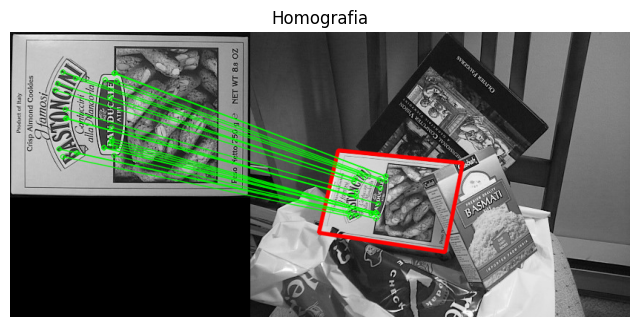

In [18]:
# Parámetros para dibujar las correspondencias
draw_params = dict(matchColor = (0,255,0),    # Matches en verde
                   singlePointColor = None,
                   matchesMask = matchesMask, # Dibujar solo inliners (según RANSAC)
                   flags = 2)
# Imagen de salida (I1 con I2 con matches)
Iout = cv2.drawMatches(I1, keypts1, I2, keypts2, good_matches, None, **draw_params)

plt.figure(figsize=(8,8))
plt.imshow(Iout); plt.axis('off'); plt.title('Homografia')
plt.show()

# 2.&nbsp;Homografía usando SIFT

In [6]:
# Descriptores usando SIFT
sift = cv2.SIFT_create()
keypts1, descriptores1 = sift.detectAndCompute(I1, None)
keypts2, descriptores2 = sift.detectAndCompute(I2, None)

In [7]:
# # Parámetros de correspondencia usando FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
# Correspondencia usando FLANN
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptores1, descriptores2, k=2)

# Correspondencias adecuadas según el ratio
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

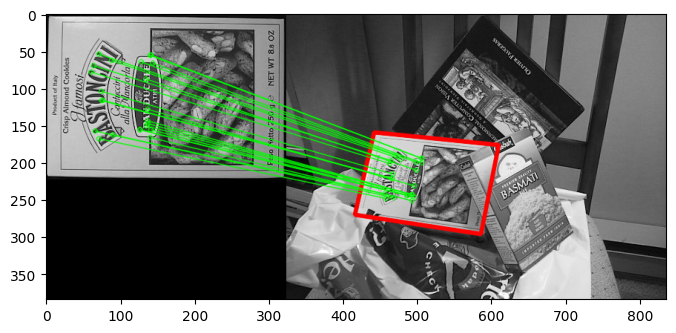

In [19]:
MIN_NUM_GOOD_MATCHES = 10

if len(good_matches) >= MIN_NUM_GOOD_MATCHES:
    # Coordenadas 2D de los correspondientes keypoints
    src_pts = np.float32( [keypts1[m.queryIdx].pt for m in good_matches] ).reshape(-1, 1, 2)
    dst_pts = np.float32( [keypts2[m.trainIdx].pt for m in good_matches] ).reshape(-1, 1, 2)

    # Homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    mask_matches = mask.ravel().tolist()

    # Transformación de perspectiva: proyectar los bordes rectangulares
    # en la escena para dibujar un borde
    h, w = I1.shape
    src_corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst_corners = cv2.perspectiveTransform(src_corners, M)
    dst_corners = dst_corners.astype(np.int32)

    # Dibujar los bordes de la región correspondiente
    num_corners = len(dst_corners)
    for i in range(num_corners):
        x0, y0 = dst_corners[i][0]
        if i == num_corners - 1:
            next_i = 0
        else:
            next_i = i + 1
        x1, y1 = dst_corners[next_i][0]
        cv2.line(I2, (x0, y0), (x1, y1), 255, 3, cv2.LINE_AA)

    # Dibujar correspondencias que pasaron el test de ratio
    img_matches = cv2.drawMatches(I1, keypts1, I2, keypts2, good_matches,
                                  None, matchColor=(0, 255, 0),
                                  singlePointColor=None,
                                  matchesMask=mask_matches, flags=2)

    # Mostrar la homografía y los matches
    plt.figure(figsize=(8,8))
    plt.imshow(img_matches)
    plt.show()
else:
    print("No hay suficientes correspondencias")

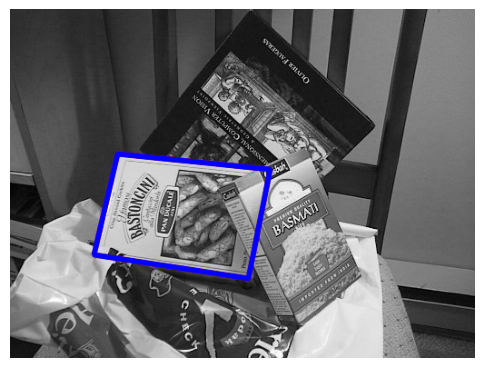

In [21]:
# Mismo resultado pero solo el objeto detectado

# Bordes detectados
num_corners = len(dst_corners)
for i in range(num_corners):
    x0, y0 = dst_corners[i][0]
    if i == num_corners - 1:
        next_i = 0
    else:
        next_i = i + 1
    x1, y1 = dst_corners[next_i][0]
    cv2.line(I2, (x0, y0), (x1, y1), (0, 0, 255), 3, cv2.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(I2)
plt.axis('off'); plt.show()

# 3.&nbsp;Aplicación: Panorama

In [10]:
I1 = cv2.imread('pan1.jpg')
I2 = cv2.imread('pan2.jpg')

I1gr = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2gr = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# Inicializar el descriptor ORB
orb = cv2.ORB_create()
# 'Keypoints' y descriptores para cada imagen (usando ORB)
keypts1, descript1 = orb.detectAndCompute(I1gr, None)
keypts2, descript2 = orb.detectAndCompute(I2gr, None)

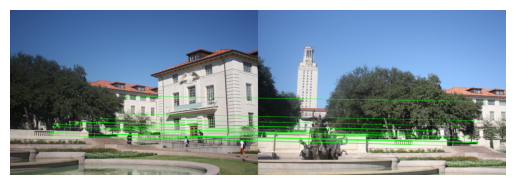

In [11]:
# Matcher
match = cv2.BFMatcher()
matches = match.knnMatch(descript1, descript2, k=2)
good_matches = []
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good_matches.append(m)

# Dibujar los "matches" (las correspondencias)
draw_params = dict(matchColor=(0,255,0), singlePointColor = None, flags = 2)
Imatch = cv2.drawMatches(I1, keypts1, I2, keypts2, good_matches, None, **draw_params)

# Correspondencias originales
plt.imshow(Imatch[:,:,::-1])
plt.axis('off');

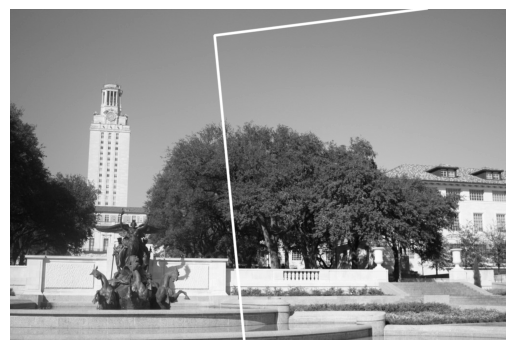

In [12]:
# Encontrar la homografía dados los puntos correspondientes
MIN_MATCH_COUNT = 10
if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([ keypts1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypts2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    h,w = I1gr.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(I2gr, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    # Área de superposición
    plt.imshow(I2gr, cmap='gray'); plt.axis('off');
else:
    print ("No se encuentran suficientes correspondencias - {}/{}".
           format(len(good_matches),MIN_MATCH_COUNT))

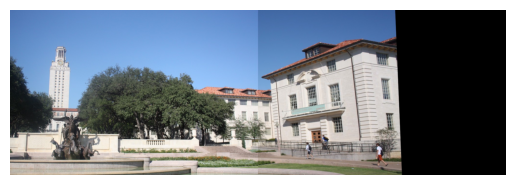

In [13]:
# Panorama usando la homografía
dst = cv2.warpPerspective(I1, M, (I2.shape[1] + I1.shape[1], I2.shape[0]))
dst[0:I2.shape[0],0:I2.shape[1]] = I2

# Panorama con partes negras
plt.imshow(dst[:,:,::-1])
plt.axis('off');

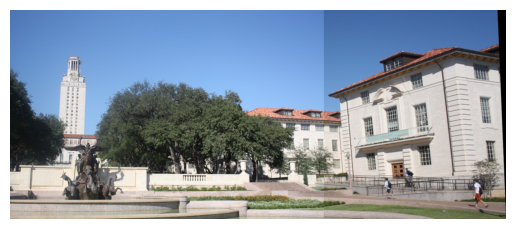

In [14]:
# Eliminar la parte negra del panorama
def trim(frame):
    # Cortar la imagen
    if not np.sum(frame[0]): return trim(frame[1:])
    if not np.sum(frame[-1]): return trim(frame[:-2])
    if not np.sum(frame[:,0]): return trim(frame[:,1:])
    if not np.sum(frame[:,-1]): return trim(frame[:,:-2])
    return frame

# Mostrar la imagen
plt.imshow(trim(dst)[:,:,::-1])
plt.axis('off');